In [3]:
import numpy as np
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.porter import PorterStemmer
import collections
from tqdm import tqdm_notebook as tqdm
from networkx.algorithms import approximation
from scipy import sparse

In [2]:
# DF parallelization chunk

from multiprocessing import  Pool
from functools import partial
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn import preprocessing
#tqdm_notebook.pandas()

def parallelize(data, func, num_of_processes=11):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)
    #return data_subset.progress_apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=11):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

#Instead of df.apply(some_func, axis=1)
#Use parallelize_on_rows(df, some_func)

### Read AMiner Dataset and Build Adjascency Matrix and Features

In [30]:
paper_author = pd.read_csv('data_aminer/paper_author.txt', sep = '\t', header = None, names = ['paper', 'author'])
paper_conf   = pd.read_csv('data_aminer/paper_conf.txt', sep = '\t', header = None, names = ['paper', 'conf'])

In [34]:
id_paper = pd.read_csv('data_aminer/paper.txt', sep = '\t', header = None, names = ['id', 'paper'])
id_author = pd.read_csv('data_aminer/id_author.txt', sep = '\t', header = None, names = ['id', 'author'])
id_conference =  pd.read_csv('data_aminer/id_conf.txt', sep = '\t', header = None, names = ['id', 'conference'])

In [35]:
paper_author['paper_node'] = 'p' + paper_author['paper'].astype(str)
paper_author['author_node'] = 'a' + paper_author['author'].astype(str)

paper_conf['paper_node'] = 'p' + paper_conf['paper'].astype(str)
paper_conf['conf_node'] = 'c' + paper_conf['conf'].astype(str)

In [36]:
## Search for Connference

id_author[id_author['author'].str.contains('FrankThomsonLeighton')]

,id,author
1442893,39369,aFrankThomsonLeighton


In [37]:
aminer_edgelist = pd.DataFrame(columns = ['to', 'from'])

aminer_edgelist['to'] = list(paper_author['paper_node']) + list(paper_conf['paper_node'])
aminer_edgelist['from'] = list(paper_author['author_node']) + list(paper_conf['conf_node'])

In [38]:
aminer_graph = nx.from_pandas_edgelist(aminer_edgelist, source = 'from', target = 'to')

In [39]:
len(aminer_graph.edges)

12518010

In [40]:
len(aminer_graph.nodes)

4891819

In [50]:
id_conference

,id,conference
0,1200,vICTSS
1,3734,vIJIMAI
2,3724,vComputationalIntelligence
3,3725,vIJTHI
4,3798,vComputerMethodsandProgramsinBiomedicine
...,...,...
3878,479,vComputerGraphicsandImageProcessing
3879,2916,vOptimizationTechniques
3880,3699,vJ.Sensors
3881,1368,vBerkeleyWorkshop


### Plot Degree Distribution

In [41]:
degree_sequence = sorted([d for n, d in aminer_graph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_dataframe = pd.DataFrame({'degree': deg, 'count': cnt})
degree_dataframe = degree_dataframe.set_index('degree', drop = True)

In [15]:
high_degree_dataframe = degree_dataframe[degree_dataframe['count'] > 100]

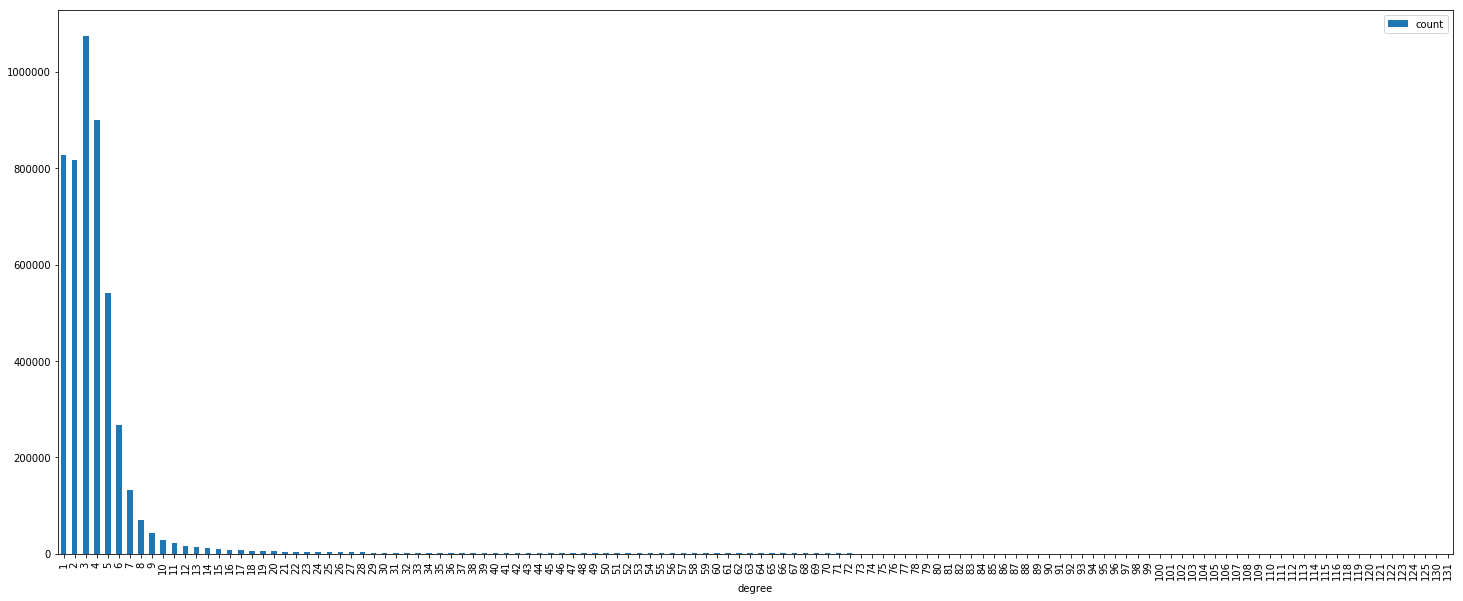

In [16]:
binned  = high_degree_dataframe.groupby(high_degree_dataframe.index // 1).sum()
binned.plot.bar(figsize=(25,10))

### Remove low degree nodes from graph

In [42]:
node_degree_df = pd.DataFrame(aminer_graph.degree(), columns = ['node', 'degree']).set_index('node', drop = True)

In [43]:
low_degree_dataframe = node_degree_df[node_degree_df['degree'] < 20]

len(low_degree_dataframe)/len(aminer_graph.nodes)

0.9807169889155751

In [44]:
low_degree_set = set(list(low_degree_dataframe.index))
aminer_graph.remove_nodes_from([n for n in tqdm(aminer_graph) if n in low_degree_set])

In [45]:
aminer_graph.nodes

NodeView(('a188315', 'a523363', 'a18912', 'c94', 'a75387', 'a1242595', 'a63687', 'a52521', 'a496217', 'a272609', 'a852248', 'a69816', 'a28947', 'a374760', 'a521165', 'a253924', 'a170301', 'a42220', 'a20887', 'a105397', 'a20190', 'a324510', 'a248317', 'a132656', 'a144957', 'a64759', 'a70861', 'a249754', 'a20499', 'a313750', 'a101237', 'a388498', 'a383105', 'a197078', 'a28361', 'a252415', 'a127966', 'a296247', 'a144939', 'a369611', 'a8284', 'a400701', 'a128229', 'p2116704', 'c969', 'a20357', 'a144358', 'a250024', 'c758', 'c1655', 'a822086', 'a404491', 'a338293', 'a111951', 'a21857', 'a57420', 'a374345', 'a124752', 'a8161', 'a423471', 'a253244', 'a1646452', 'a20098', 'a1021755', 'a369646', 'a57776', 'a598146', 'a110745', 'a154316', 'a246126', 'a246826', 'a35328', 'a70076', 'a30514', 'a12051', 'a519600', 'a44416', 'a291', 'a224280', 'a46594', 'a246046', 'a147977', 'a136075', 'a117109', 'a214611', 'a330770', 'a47533', 'a250744', 'c691', 'a114827', 'a1382', 'a12842', 'a509820', 'a86922', 'a5

In [19]:
len(aminer_graph.nodes)

94329

In [20]:
len(aminer_graph.edges)

13101

In [48]:
aminer_graph.nodes

NodeView(('a188315', 'a523363', 'a18912', 'c94', 'a75387', 'a1242595', 'a63687', 'a52521', 'a496217', 'a272609', 'a852248', 'a69816', 'a28947', 'a374760', 'a521165', 'a253924', 'a170301', 'a42220', 'a20887', 'a105397', 'a20190', 'a324510', 'a248317', 'a132656', 'a144957', 'a64759', 'a70861', 'a249754', 'a20499', 'a313750', 'a101237', 'a388498', 'a383105', 'a197078', 'a28361', 'a252415', 'a127966', 'a296247', 'a144939', 'a369611', 'a8284', 'a400701', 'a128229', 'p2116704', 'c969', 'a20357', 'a144358', 'a250024', 'c758', 'c1655', 'a822086', 'a404491', 'a338293', 'a111951', 'a21857', 'a57420', 'a374345', 'a124752', 'a8161', 'a423471', 'a253244', 'a1646452', 'a20098', 'a1021755', 'a369646', 'a57776', 'a598146', 'a110745', 'a154316', 'a246126', 'a246826', 'a35328', 'a70076', 'a30514', 'a12051', 'a519600', 'a44416', 'a291', 'a224280', 'a46594', 'a246046', 'a147977', 'a136075', 'a117109', 'a214611', 'a330770', 'a47533', 'a250744', 'c691', 'a114827', 'a1382', 'a12842', 'a509820', 'a86922', 'a5

### Create adjascency matrix

In [22]:
aminer_adj = nx.adjacency_matrix(aminer_graph)

In [26]:
with open('intermediate_pkl/aminer_adj.pkl', 'wb') as f:
    pkl.dump(aminer_adj, f)

In [13]:
with open('intermediate_pkl/aminer_adj.pkl', 'rb') as f:
    aminer_adj = pkl.load(f)

In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Create feature matrix

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/omai.r/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/omai.r/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#stemmer = PorterStemmer()
#id_paper['paper_tokens'] = id_paper['paper'].apply(lambda x: [w for w in word_tokenize(str(x).lower()) if (w not in stop) and (w.isalpha())])
#id_paper['paper_tokens'] = id_paper['paper_tokens'].apply(lambda x: [set(stemmer.stem(w)) for w in x])

In [46]:
id_paper = pd.read_csv('data_aminer/paper.txt', sep = '\t', header = None, names = ['id', 'paper'])

In [47]:
id_paper.join()

,id,paper
0,0,Parallel Integer Sorting and Simulation Amongs...
1,1,Pattern Matching in Trees and Nets.
2,2,NP-complete Problems Simplified on Tree Schemas.
3,3,On the Power of Chain Rules in Context Free Gr...
4,4,Schnelle Multiplikation von Polynomen &uuml;be...


In [12]:
%%time
stemmer = PorterStemmer()

def tokenize_send_to_pool(x, axis):
    stop = set(stopwords.words('english'))
    return [w for w in word_tokenize(str(x).lower()) if (w not in stop) and (w.isalpha())]

id_paper['paper_tokens'] = parallelize_on_rows(id_paper['paper'], tokenize_send_to_pool)

CPU times: user 10.3 s, sys: 3.38 s, total: 13.7 s
Wall time: 2min 29s


In [13]:
%%time

def stem_send_to_pool(x, axis):
    return set([stemmer.stem(w) for w in x])

id_paper['paper_tokens'] = parallelize_on_rows(id_paper['paper_tokens'], stem_send_to_pool)

CPU times: user 42.9 s, sys: 10.4 s, total: 53.3 s
Wall time: 1min 59s


In [12]:
id_paper['paper_tokens']

0          {model, amongst, sort, parallel, crcw, simul, ...
1                                {tree, match, pattern, net}
2                          {tree, simplifi, problem, schema}
3               {rule, power, free, context, grammar, chain}
4          {rpern, k, multiplik, von, schnell, uuml, ouml...
                                 ...                        
3192139      {measur, approach, comparison, topolog, proxim}
3192140                           {log, summar, olap, queri}
3192141    {rule, associ, discrimin, probabilist, measur,...
3192142    {rule, binari, robust, classif, set, criterion...
3192143                  {mine, sequenti, approach, pattern}
Name: paper_tokens, Length: 3192144, dtype: object

In [19]:
with open('intermediate_pkl/feature_df.pkl', 'wb') as f:
    pkl.dump(id_paper, f)

In [14]:
with open('intermediate_pkl/feature_df.pkl', 'rb') as f:
    id_paper = pkl.load(f)

## One Hot Encoding - One hot encoding in the original dataframe - MemoryError

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

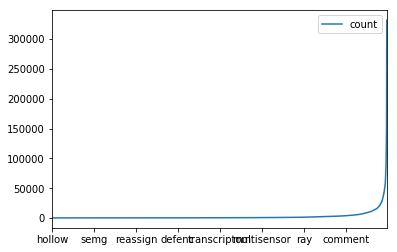

In [106]:

features_tokenized = {}
X = []
threshold = 100

for i in tqdm(id_paper['paper_tokens']):
    for j in i:
        if j not in features_tokenized:
            features_tokenized.update({j: 1})
        else:
            features_tokenized[j] += 1 

features_tokenized_df = pd.DataFrame.from_dict(features_tokenized, orient = 'index', columns = ['count'])
features_tokenized_df = features_tokenized_df[features_tokenized_df['count'] > threshold]
features_tokenized_df.sort_values('count').plot()
features_tokenized = features_tokenized_df.to_dict(orient = 'index')
features_tokenized = {i: v['count'] for  i, v in features_tokenized.items()}

onehot_encoder = OneHotEncoder()
onehot_encoder.fit(np.array(list(features_tokenized_df.index)).reshape(1, -1))


In [ ]:
def one_hot_to_pool(x, axis):

    x = [i for i in x if i in features_tokenized]
    if len(x) != 0:
        return np.array(sum(onehot_encoder.transform(np.array(x).reshape(-1,1)).todense()))[0]
    else:
        return np.zeros((1,len(features_tokenized)))
    
#id_paper['one_hot'] = parallelize_on_rows(id_paper['paper_tokens'], tokenize_send_to_pool)

## One Hot Encoding 2 - Seperate Dataframe for OneHot - Takes too long

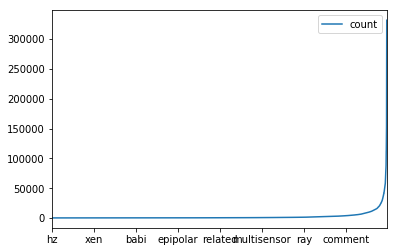

In [13]:
features_tokenized = {}
threshold = 100
X = []

## Filter out words below threshold
for i in tqdm(id_paper['paper_tokens']):
    for j in i:
        if j not in features_tokenized:
            features_tokenized.update({j: 1})
        else:
            features_tokenized[j] += 1 

features_tokenized_df = pd.DataFrame.from_dict(features_tokenized, orient = 'index', columns = ['count'])
features_tokenized_df = features_tokenized_df[features_tokenized_df['count'] > threshold]
features_tokenized_df.sort_values('count').plot()
features_tokenized = features_tokenized_df.to_dict(orient = 'index')
features_tokenized = {i: v['count'] for  i, v in features_tokenized.items()}

## Create the matrix X after filtering

for i, v1 in tqdm(enumerate(id_paper['paper_tokens'])):
    X.append([])
    for j, v2 in enumerate(v1):
        if v2 in features_tokenized:
            X[i].append(v2)

In [18]:
%%time 
## Convert NA to empty string

X_df = pd.DataFrame(X)

mask = X_df.applymap(lambda x: x is None)
cols = X_df.columns[(mask).any()]

for col in X_df[cols]:
    X_df.loc[mask[col], col] = ''

X_df.head()

KeyboardInterrupt: 

In [17]:
onehot_encoder = OneHotEncoder(categories = 'auto')
onehot_encoder.fit_transform(X_df.values).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## One Hot Encoding 3 - Try with Label Encong and Bypass Pandas

In [7]:
le = preprocessing.LabelEncoder()

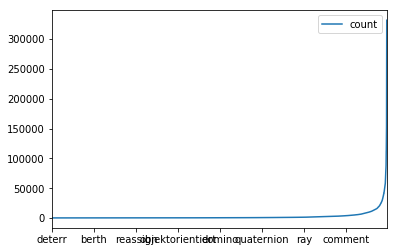

In [4]:
features_tokenized = {}
threshold = 100

for i in tqdm(id_paper['paper_tokens']):
    for j in i:
        if j not in features_tokenized:
            features_tokenized.update({j: 1})
        else:
            features_tokenized[j] += 1 

features_tokenized_df = pd.DataFrame.from_dict(features_tokenized, orient = 'index', columns = ['count'])
features_tokenized_df = features_tokenized_df[features_tokenized_df['count'] > threshold]
features_tokenized_df.sort_values('count').plot()
features_tokenized = features_tokenized_df.to_dict(orient = 'index')
features_tokenized = {i: v['count'] for  i, v in features_tokenized.items()}

In [12]:
le.fit(np.array(list(features_tokenized_df.index)))

LabelEncoder()

In [17]:
id_paper['paper_tokens'][0]

{'amongst', 'crcw', 'integ', 'model', 'parallel', 'simul', 'sort'}

In [20]:
def label_encoder_to_pool(x, axis):
    
    x = [i for i in x if i in features_tokenized]
    
    if len(x) != 0:
        return list(np.array(le.transform(x)) + 1)
    else:
        return 0
    
id_paper['one_hot'] = parallelize_on_rows(id_paper['paper_tokens'], label_encoder_to_pool)

In [21]:
id_paper['one_hot']

0                        [5096, 6585, 3539, 6450, 4421, 227]
1                                   [4705, 5148, 4179, 7333]
2                                   [5537, 6449, 7333, 6216]
3                       [5442, 6152, 2802, 1068, 2995, 1442]
4                        [7581, 5013, 1838, 7731, 3748, 660]
                                 ...                        
3192139                        [4220, 334, 5610, 1321, 7240]
3192140                             [6884, 4010, 5707, 4926]
3192141      [5533, 3565, 1978, 6152, 1320, 7409, 4220, 427]
3192142    [617, 6152, 6350, 1693, 2461, 718, 1577, 1178,...
3192143                              [6337, 5148, 334, 4368]
Name: one_hot, Length: 3192144, dtype: object

In [22]:
with open('intermediate_pkl/feature_df_w_label_encoder.pkl', 'wb') as f:
    pkl.dump(id_paper, f)

In [7]:
with open('intermediate_pkl/feature_df_w_label_encoder.pkl', 'rb') as f:
    id_paper = pkl.load(f)

In [8]:
id_paper['one_hot'].values[0]

[5096, 6585, 3539, 6450, 4421, 227]

In [9]:
enc = OneHotEncoder(sparse = True)
enc.fit(np.array((range(len(features_tokenized_df) + 1))).reshape(-1,1))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [6]:
enc.transform(np.array(id_paper['one_hot'][0]).reshape(-1,1))

<6x7978 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [7]:
def onehot_to_pool(x, axis):
    
    if x != 0:
        return enc.transform(np.array(list(x)).reshape(-1,1))
    else:
        return sparse.csr_matrix(np.zeros((1, len(features_tokenized_df) + 1)))
        
one_hot_encoded_vectors = parallelize_on_rows(id_paper['one_hot'], onehot_to_pool)
#id_paper['one_hot'] = parallelize_on_rows(id_paper['paper_tokens'], onehot_to_pool)

In [21]:
len(features_tokenized_df)

7977

In [15]:
with open('intermediate_pkl/feature_one_hot_vectors.pkl', 'wb') as f:
    pkl.dump(one_hot_encoded_vectors, f)

In [4]:
with open('intermediate_pkl/feature_one_hot_vectors.pkl', 'rb') as f:
    one_hot_encoded_vectors = pkl.load(f)

### Takes too long

In [ ]:
one_hot_encoded_matrix = one_hot_encoded_vectors[0]

for i, row in enumerate(tqdm(one_hot_encoded_vectors[1:])):
    
    try:
        one_hot_encoded_matrix = sparse.vstack([one_hot_encoded_matrix, row])

    except:
        print(one_hot_encoded_matrix.shape)
        print(row.shape)

(728, 7978)
(1, 7977)
(1065, 7978)
(1, 7977)
(1756, 7978)
(1, 7977)
(1931, 7978)
(1, 7977)
(3472, 7978)
(1, 7977)
(4030, 7978)
(1, 7977)
(4102, 7978)
(1, 7977)
(4362, 7978)
(1, 7977)
(4807, 7978)
(1, 7977)
(8043, 7978)
(1, 7977)
(23418, 7978)
(1, 7977)
(34677, 7978)
(1, 7977)
(34694, 7978)
(1, 7977)
(39750, 7978)
(1, 7977)
(76233, 7978)
(1, 7977)
(76629, 7978)
(1, 7977)
(87180, 7978)
(1, 7977)
(104882, 7978)
(1, 7977)
(106648, 7978)
(1, 7977)
(106902, 7978)
(1, 7977)
(119444, 7978)
(1, 7977)
(132576, 7978)
(1, 7977)
(142541, 7978)
(1, 7977)
(146033, 7978)
(1, 7977)
(149372, 7978)
(1, 7977)
(150791, 7978)
(1, 7977)
(152168, 7978)
(1, 7977)
(158066, 7978)
(1, 7977)
(159459, 7978)
(1, 7977)
(159518, 7978)
(1, 7977)
(159621, 7978)
(1, 7977)
(160181, 7978)
(1, 7977)
(160266, 7978)
(1, 7977)
(160838, 7978)
(1, 7977)
(163879, 7978)
(1, 7977)
(166011, 7978)
(1, 7977)
(171810, 7978)
(1, 7977)
(173167, 7978)
(1, 7977)
(174642, 7978)
(1, 7977)
(174768, 7978)
(1, 7977)
(175105, 7978)
(1, 7977)
(20

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(1035627, 7978)
(1, 7977)
(1035805, 7978)
(1, 7977)
(1035921, 7978)
(1, 7977)
(1036065, 7978)
(1, 7977)
(1036724, 7978)
(1, 7977)
(1037218, 7978)
(1, 7977)
(1037673, 7978)
(1, 7977)
(1037699, 7978)
(1, 7977)
(1037740, 7978)
(1, 7977)
(1037876, 7978)
(1, 7977)
(1037942, 7978)
(1, 7977)
(1068437, 7978)
(1, 7977)
(1079816, 7978)
(1, 7977)
(1082853, 7978)
(1, 7977)
(1083053, 7978)
(1, 7977)
(1083099, 7978)
(1, 7977)
(1083207, 7978)
(1, 7977)
(1083237, 7978)
(1, 7977)
(1083625, 7978)
(1, 7977)
(1083651, 7978)
(1, 7977)
(1083651, 7978)
(1, 7977)
(1083685, 7978)
(1, 7977)
(1083825, 7978)
(1, 7977)
(1084160, 7978)
(1, 7977)
(1084452, 7978)
(1, 7977)
(1084499, 7978)
(1, 7977)
(1084586, 7978)
(1, 7977)
(1084616, 7978)
(1, 7977)
(1084686, 7978)
(1, 7977)
(1084729, 7978)
(1, 7977)
(1085006, 7978)
(1, 7977)
(1085103, 7978)
(1, 7977)
(1085428, 7978)
(1, 7977)
(1085724, 7978)
(1, 7977)
(1085797, 7978)
(1, 7977)
(1086222, 7978)
(1, 7977)
(1086390, 7978)
(1, 7977)
(1086883, 7978)
(1, 7977)
(1087032, 79

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(1266662, 7978)
(1, 7977)
(1274111, 7978)
(1, 7977)
(1275257, 7978)
(1, 7977)
(1276684, 7978)
(1, 7977)
(1277636, 7978)
(1, 7977)
(1278286, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(1422585, 7978)
(1, 7977)
(1428430, 7978)
(1, 7977)
(1428765, 7978)
(1, 7977)
(1429704, 7978)
(1, 7977)
(1433198, 7978)
(1, 7977)
(1441923, 7978)
(1, 7977)
(1443325, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(1613784, 7978)
(1, 7977)
(1614359, 7978)
(1, 7977)
(1614488, 7978)
(1, 7977)
(1614625, 7978)
(1, 7977)
(1614728, 7978)
(1, 7977)
(1614728, 7978)
(1, 7977)
(1614764, 7978)
(1, 7977)
(1614772, 7978)
(1, 7977)
(1614803, 7978)
(1, 7977)
(1614835, 7978)
(1, 7977)
(1614924, 7978)
(1, 7977)
(1614967, 7978)
(1, 7977)
(1615020, 7978)
(1, 7977)
(1615059, 7978)
(1, 7977)
(1615092, 7978)
(1, 7977)
(1615161, 7978)
(1, 7977)
(1615367, 7978)
(1, 7977)
(1615386, 7978)
(1, 7977)
(1615390, 7978)
(1, 7977)
(1649470, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(1748238, 7978)
(1, 7977)
(1748696, 7978)
(1, 7977)
(1749484, 7978)
(1, 7977)
(1749951, 7978)
(1, 7977)
(1750183, 7978)
(1, 7977)
(1751274, 7978)
(1, 7977)
(1774988, 7978)
(1, 7977)
(1776794, 7978)
(1, 7977)
(1780711, 7978)
(1, 7977)
(1785570, 7978)
(1, 7977)
(1785617, 7978)
(1, 7977)
(1787802, 7978)
(1, 7977)
(1791884, 7978)
(1, 7977)
(1798467, 7978)
(1, 7977)
(1800594, 7978)
(1, 7977)
(1800883, 7978)
(1, 7977)
(1801040, 7978)
(1, 7977)
(1801780, 7978)
(1, 7977)
(1812482, 7978)
(1, 7977)
(1812938, 7978)
(1, 7977)
(1814852, 7978)
(1, 7977)
(1815898, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(1954559, 7978)
(1, 7977)
(1954753, 7978)
(1, 7977)
(1954859, 7978)
(1, 7977)
(1955299, 7978)
(1, 7977)
(1955329, 7978)
(1, 7977)
(1955329, 7978)
(1, 7977)
(1955475, 7978)
(1, 7977)
(1955645, 7978)
(1, 7977)
(1955654, 7978)
(1, 7977)
(1955937, 7978)
(1, 7977)
(1955988, 7978)
(1, 7977)
(1956006, 7978)
(1, 7977)
(1956047, 7978)
(1, 7977)
(1956064, 7978)
(1, 7977)
(1956077, 7978)
(1, 7977)
(1956143, 7978)
(1, 7977)
(1980045, 7978)
(1, 7977)
(1983225, 7978)
(1, 7977)
(2024503, 7978)
(1, 7977)
(2048631, 7978)
(1, 7977)
(2057220, 7978)
(1, 7977)
(2059812, 7978)
(1, 7977)
(2103011, 7978)
(1, 7977)
(2103715, 7978)
(1, 7977)
(2118982, 7978)
(1, 7977)
(2122356, 7978)
(1, 7977)
(2123477, 7978)
(1, 7977)
(2144477, 7978)
(1, 7977)
(2144577, 7978)
(1, 7977)
(2145916, 7978)
(1, 7977)
(2146865, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 7978)
(1, 7977)
(2151979, 79

(2531455, 7978)
(1, 7977)
(2531650, 7978)
(1, 7977)
(2531682, 7978)
(1, 7977)
(2531734, 7978)
(1, 7977)
(2531757, 7978)
(1, 7977)
(2532310, 7978)
(1, 7977)
(2532334, 7978)
(1, 7977)
(2533228, 7978)
(1, 7977)
(2534795, 7978)
(1, 7977)
(2536936, 7978)
(1, 7977)
(2540224, 7978)
(1, 7977)
(2547924, 7978)
(1, 7977)
(2550182, 7978)
(1, 7977)
(2551783, 7978)
(1, 7977)
(2552293, 7978)
(1, 7977)
(2554700, 7978)
(1, 7977)
(2556769, 7978)
(1, 7977)
(2559820, 7978)
(1, 7977)
(2566684, 7978)
(1, 7977)
(2568502, 7978)
(1, 7977)
(2593771, 7978)
(1, 7977)
(2593818, 7978)
(1, 7977)
(2593889, 7978)
(1, 7977)
(2595275, 7978)
(1, 7977)
(2595431, 7978)
(1, 7977)
(2597912, 7978)
(1, 7977)
(2600333, 7978)
(1, 7977)
(2601908, 7978)
(1, 7977)
(2604796, 7978)
(1, 7977)
(2605959, 7978)
(1, 7977)
(2607011, 7978)
(1, 7977)
(2654502, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(2731904, 7978)
(1, 7977)
(2738747, 7978)
(1, 7977)
(2745541, 7978)
(1, 7977)
(2748197, 7978)
(1, 7977)
(2748804, 7978)
(1, 7977)
(2751089, 7978)
(1, 7977)
(2751780, 7978)
(1, 7977)
(2753942, 7978)
(1, 7977)
(2756080, 7978)
(1, 7977)
(2757269, 7978)
(1, 7977)
(2759972, 7978)
(1, 7977)
(2761603, 7978)
(1, 7977)
(2763337, 7978)
(1, 7977)
(2764318, 7978)
(1, 7977)
(2765058, 7978)
(1, 7977)
(2766379, 7978)
(1, 7977)
(2793347, 7978)
(1, 7977)
(2793726, 7978)
(1, 7977)
(2796820, 7978)
(1, 7977)
(2801981, 7978)
(1, 7977)
(2802004, 7978)
(1, 7977)
(2802038, 7978)
(1, 7977)
(2802043, 7978)
(1, 7977)
(2802050, 7978)
(1, 7977)
(2802050, 7978)
(1, 7977)
(2802064, 7978)
(1, 7977)
(2802084, 7978)
(1, 7977)
(2802111, 7978)
(1, 7977)
(2802166, 7978)
(1, 7977)
(2802201, 7978)
(1, 7977)
(2802201, 7978)
(1, 7977)
(2802256, 7978)
(1, 7977)
(2802261, 7978)
(1, 7977)
(2802290, 7978)
(1, 7977)
(2802317, 7978)
(1, 7977)
(2802339, 7978)
(1, 7977)
(2802350, 7978)
(1, 7977)
(2802395, 7978)
(1, 7977)
(2802422, 79

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(2926522, 7978)
(1, 7977)
(2942427, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2945008, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 7978)
(1, 7977)
(2947398, 79

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3038720, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3104384, 7978)
(1, 7977)
(3104564, 7978)
(1, 7977)
(3104911, 7978)
(1, 7977)
(3105013, 7978)
(1, 7977)
(3105055, 7978)
(1, 7977)
(3105268, 7978)
(1, 7977)
(3105293, 7978)
(1, 7977)
(3105376, 7978)
(1, 7977)
(3105454, 7978)
(1, 7977)
(3105500, 7978)
(1, 7977)
(3105562, 7978)
(1, 7977)
(3105773, 7978)
(1, 7977)
(3105773, 7978)
(1, 7977)
(3105902, 7978)
(1, 7977)
(3105994, 7978)
(1, 7977)
(3106471, 7978)
(1, 7977)
(3106520, 7978)
(1, 7977)
(3106574, 7978)
(1, 7977)
(3106664, 7978)
(1, 7977)
(3106672, 7978)
(1, 7977)
(3106723, 7978)
(1, 7977)
(3106753, 7978)
(1, 7977)
(3107015, 7978)
(1, 7977)
(3107081, 7978)
(1, 7977)
(3110011, 7978)
(1, 7977)
(3117960, 7978)
(1, 7977)
(3120141, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3167496, 7978)
(1, 7977)
(3173009, 7978)
(1, 7977)
(3173627, 7978)
(1, 7977)
(3174054, 7978)
(1, 7977)
(3174850, 7978)
(1, 7977)
(3176234, 7978)
(1, 7977)
(3182631, 7978)
(1, 7977)
(3183118, 7978)
(1, 7977)
(3187616, 7978)
(1, 7977)
(3187701, 7978)
(1, 7977)
(3191963, 7978)
(1, 7977)
(3192326, 7978)
(1, 7977)
(3192737, 7978)
(1, 7977)
(3194321, 7978)
(1, 7977)
(3197650, 7978)
(1, 7977)
(3199127, 7978)
(1, 7977)
(3199994, 7978)
(1, 7977)
(3218165, 7978)
(1, 7977)
(3219330, 7978)
(1, 7977)
(3221739, 7978)
(1, 7977)
(3222529, 7978)
(1, 7977)
(3224232, 7978)
(1, 7977)
(3280540, 7978)
(1, 7977)
(3288445, 7978)
(1, 7977)
(3306867, 7978)
(1, 7977)
(3312369, 7978)
(1, 7977)
(3312944, 7978)
(1, 7977)
(3312962, 7978)
(1, 7977)
(3313488, 7978)
(1, 7977)
(3313735, 7978)
(1, 7977)
(3316785, 7978)
(1, 7977)
(3318506, 7978)
(1, 7977)
(3330312, 7978)
(1, 7977)
(3330770, 7978)
(1, 7977)
(3344845, 7978)
(1, 7977)
(3355823, 7978)
(1, 7977)
(3377708, 7978)
(1, 7977)
(3378589, 7978)
(1, 7977)
(3379298, 79

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3464961, 7978)
(1, 7977)
(3468855, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3518380, 7978)
(1, 7977)
(3526730, 7978)
(1, 7977)
(3529003, 7978)
(1, 7977)
(3539558, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3588647, 7978)
(1, 7977)
(3588647, 7978)
(1, 7977)
(3602702, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3649458, 7978)
(1, 7977)
(3650396, 7978)
(1, 7977)
(3651803, 7978)
(1, 7977)
(3652525, 7978)
(1, 7977)
(3658285, 7978)
(1, 7977)
(3658783, 7978)
(1, 7977)
(3658949, 7978)
(1, 7977)
(3660274, 7978)
(1, 7977)
(3663083, 7978)
(1, 7977)
(3663234, 7978)
(1, 7977)
(3664977, 7978)
(1, 7977)
(3665297, 7978)
(1, 7977)
(3667932, 7978)
(1, 7977)
(3669636, 7978)
(1, 7977)
(3670376, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3717077, 7978)
(1, 7977)
(3717736, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3783475, 7978)
(1, 7977)
(3783628, 7978)
(1, 7977)
(3784876, 7978)
(1, 7977)
(3785254, 7978)
(1, 7977)
(3785507, 7978)
(1, 7977)
(3787383, 7978)
(1, 7977)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(3824071, 7978)
(1, 7977)
(3825584, 7978)
(10, 7978)
(3828325, 7978)
(10, 7978)
(3828368, 7978)
(12, 7978)


## Attempting Divide and conquer

In [7]:
%time

def create_large_sparse(one_hot_encoded_vectors, recursion_depth = 0):
    
    recursion_depth += 1
    #print('recursion_depth:' + str(recursion_depth))
    #print('length_of_vector:' + str(len(one_hot_encoded_vectors)))
    
    if len(one_hot_encoded_vectors) > 1:
        one_hot_matrix_0 = create_large_sparse(one_hot_encoded_vectors[:int(len(one_hot_encoded_vectors)/2)], recursion_depth)
        one_hot_matrix_1 = create_large_sparse(one_hot_encoded_vectors[int(len(one_hot_encoded_vectors)/2):], recursion_depth)
        return sparse.vstack([one_hot_matrix_0, one_hot_matrix_1])
    
    else: 
        
        #print(one_hot_encoded_vectors[0].shape)
        #print(sum(one_hot_encoded_vectors[0]).shape)
        
        return sparse.csr_matrix(sum(one_hot_encoded_vectors))
    
one_hot_encoded_matrix = create_large_sparse(one_hot_encoded_vectors)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [8]:
len(one_hot_encoded_vectors)/2

1596072.0

In [9]:
np.unique(np.array(one_hot_encoded_matrix[1].todense()[0]))

array([0., 1.])

In [5]:
len(one_hot_encoded_vectors)

3192144

In [51]:
one_hot_encoded_matrix

<19997753x7978 sparse matrix of type '<class 'numpy.float64'>'
	with 19991556 stored elements in Compressed Sparse Row format>

In [11]:
with open('intermediate_pkl/feature_one_hot_matrix.pkl', 'wb') as f:
    pkl.dump(one_hot_encoded_matrix, f)

In [8]:
id_paper

,id,paper,paper_tokens,one_hot
0,0,Parallel Integer Sorting and Simulation Amongs...,"{amongst, crcw, simul, integ, model, sort, par...","[5096, 6585, 3539, 6450, 4421, 227]"
1,1,Pattern Matching in Trees and Nets.,"{pattern, tree, net, match}","[4705, 5148, 4179, 7333]"
2,2,NP-complete Problems Simplified on Tree Schemas.,"{schema, problem, tree, simplifi}","[5537, 6449, 7333, 6216]"
3,3,On the Power of Chain Rules in Context Free Gr...,"{free, power, chain, rule, context, grammar}","[5442, 6152, 2802, 1068, 2995, 1442]"
4,4,Schnelle Multiplikation von Polynomen &uuml;be...,"{ouml, ber, multiplik, k, uuml, von, der, char...","[7581, 5013, 1838, 7731, 3748, 660]"
...,...,...,...,...
3192139,3194400,Comparison of Proximity Measures: A Topologica...,"{approach, comparison, measur, proxim, topolog}","[4220, 334, 5610, 1321, 7240]"
3192140,3194401,Summarizing and Querying Logs of OLAP Queries.,"{olap, queri, summar, log}","[6884, 4010, 5707, 4926]"
3192141,3194402,Comparing Two Discriminant Probabilistic Inter...,"{interesting, compar, associ, rule, two, discr...","[5533, 3565, 1978, 6152, 1320, 7409, 4220, 427]"
3192142,3194403,A Bayesian Criterion for Evaluating the Robust...,"{bayesian, data, rule, criterion, evalu, set, ...","[617, 6152, 6350, 1693, 2461, 718, 1577, 1178,..."


In [14]:
aminer_adj

<94329x94329 sparse matrix of type '<class 'numpy.int64'>'
	with 26202 stored elements in Compressed Sparse Row format>